1.0 Data collection

In [1]:
!pip install kaggle
!pip install pandas
!pip install seaborn
!pip install pansql
!pip install xgboost
!pip install scikit-learn
!pip install -U ydata-profiling --user
!pip install --upgrade ipywidgets

In [2]:
import os
import subprocess
import zipfile
import pandas as pd
import seaborn as sns
color_pallate = sns.color_palette()
import matplotlib.pyplot as plt
import pansql as ps
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [3]:
PATH  = 'robikscube/hourly-energy-consumption'
DATA = 'Kaggle_DEC'

In [4]:
!kaggle datasets download -d {PATH}

hourly-energy-consumption.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
def download_dataset(path):
    # Run the command and capture the output
    result = subprocess.run(['kaggle', 'datasets', 'download', '-d', path], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output = result.stdout.decode('utf-8')

    print(output)  # For debugging, to see what the output is

    # Extract the filename from the path
    filename = path.split('/')[-1] + '.zip'
    return filename

path = PATH
zip_file_name = download_dataset(path)
zip_file_name

hourly-energy-consumption.zip: Skipping, found more recently modified local copy (use --force to force download)



'hourly-energy-consumption.zip'

In [6]:
with zipfile.ZipFile(zip_file_name,'r') as zip_ref:
    zip_ref.extractall(DATA)

2.0 Data preprocessing

In [7]:
df = pd.read_csv(DATA + '/PJME_hourly.csv')

In [8]:
df.set_index('Datetime', inplace=True)

In [9]:
print(df.index.dtype)
df.index = pd.to_datetime(df.index)
df.head()

object


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [10]:
print(df.dtypes)

PJME_MW    float64
dtype: object


In [11]:
df.isnull().sum()

PJME_MW    0
dtype: int64

3.0 EDA

<AxesSubplot: title={'center': 'Energy consumption'}, xlabel='Datetime'>

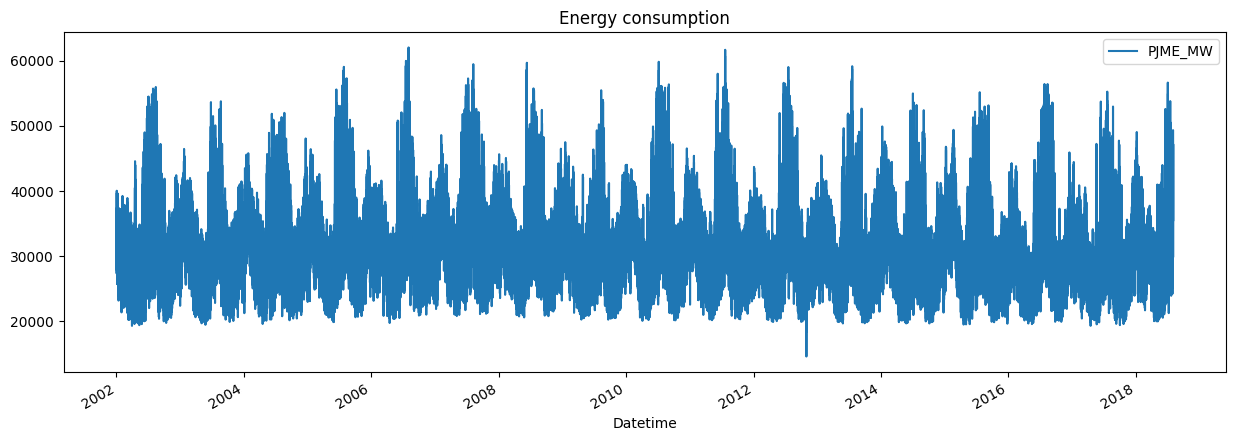

In [12]:
df.plot(figsize=(15, 5), 
        color = color_pallate[0], 
        title='Energy consumption')

<AxesSubplot: title={'center': 'Energy consumption distribution'}, ylabel='Frequency'>

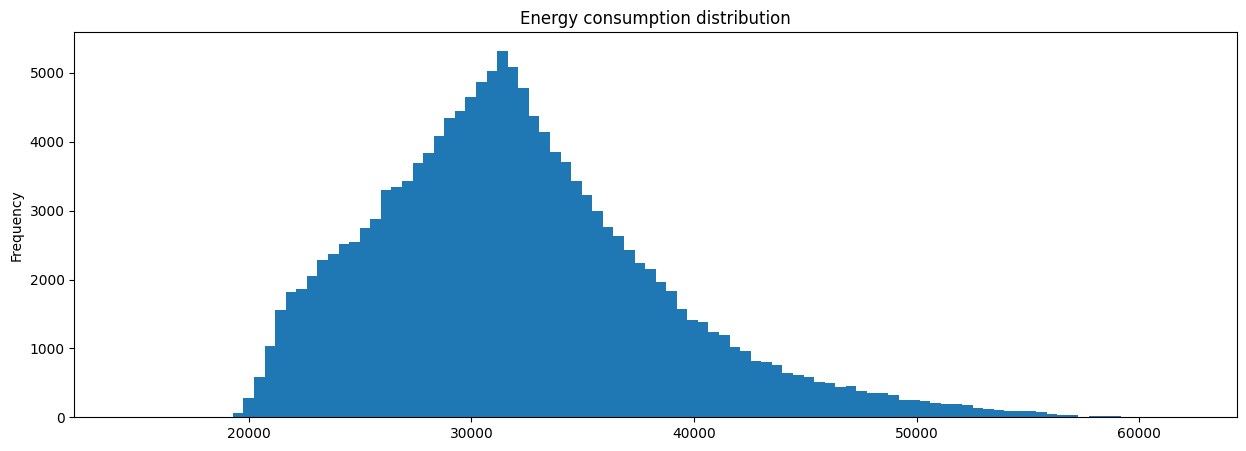

In [13]:
df['PJME_MW'].plot(kind='hist', bins=100, figsize=(15, 5), title='Energy consumption distribution')

<AxesSubplot: title={'center': 'sample of energy consumption for a week'}, xlabel='Datetime'>

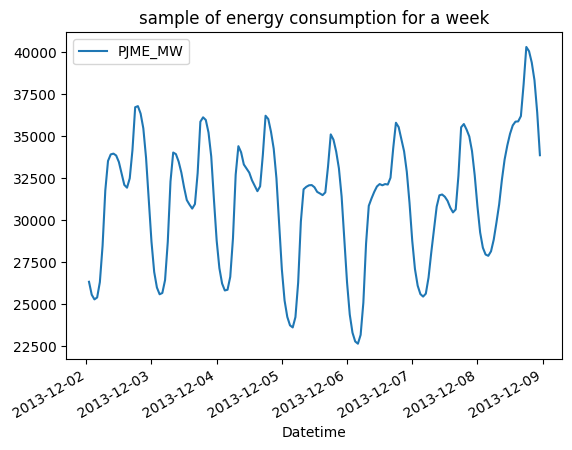

In [14]:
df.loc[(df.index > '2013-12-02') & (df.index < '2013-12-09')].plot(title='sample of energy consumption for a week')

<AxesSubplot: title={'center': 'sample of energy consumption for a day'}, xlabel='Datetime'>

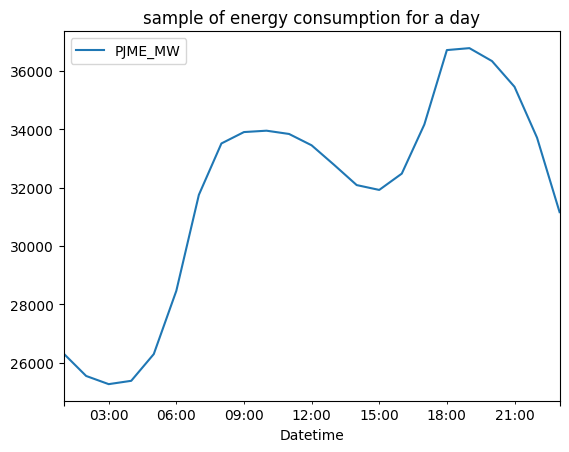

In [15]:
df.loc[(df.index > '2013-12-02') & (df.index < '2013-12-03')].plot(title='sample of energy consumption for a day')

In [16]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    return df


In [17]:
df = create_features(df)

In [18]:
query = '''
SELECT *
FROM df
WHERE dayofweek = 0
AND day <=7
AND year = 2013
AND month = 12
'''

a1 = ps.sqldf(query)
a1.head(1)

,Datetime,PJME_MW,hour,day,month,year,dayofweek
0,2013-12-02 01:00:00.000000,26317.0,1,2,12,2013,0


<AxesSubplot: xlabel='hour', ylabel='PJME_MW'>

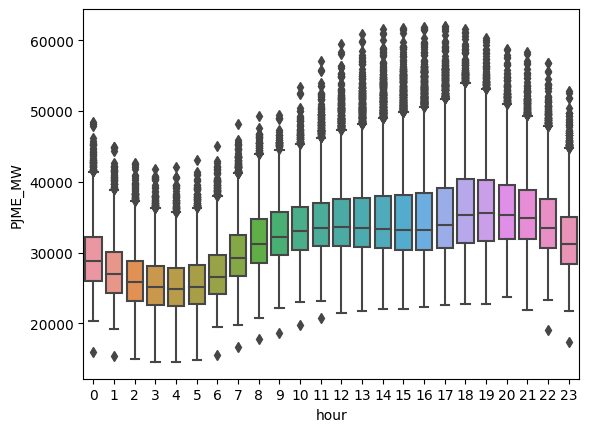

In [19]:
sns.boxplot(data=df, x='hour', y='PJME_MW')

<AxesSubplot: xlabel='dayofweek', ylabel='PJME_MW'>

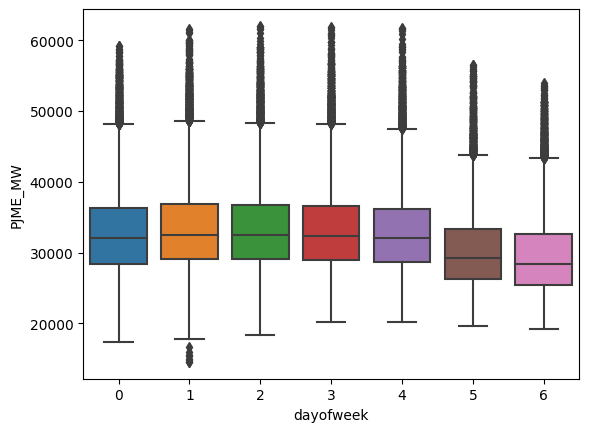

In [20]:
sns.boxplot(data=df, x='dayofweek', y='PJME_MW')

<AxesSubplot: xlabel='month', ylabel='PJME_MW'>

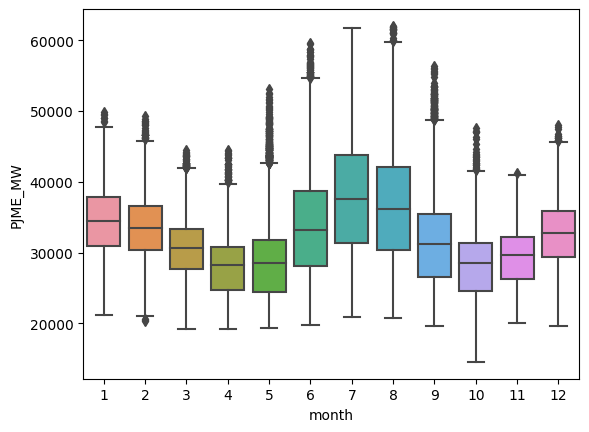

In [21]:
sns.boxplot(data=df, x='month', y='PJME_MW')

In [22]:
profile = ProfileReport(df, title='Pandas Profiling Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot: title={'center': 'extreme outliers'}, xlabel='Datetime'>

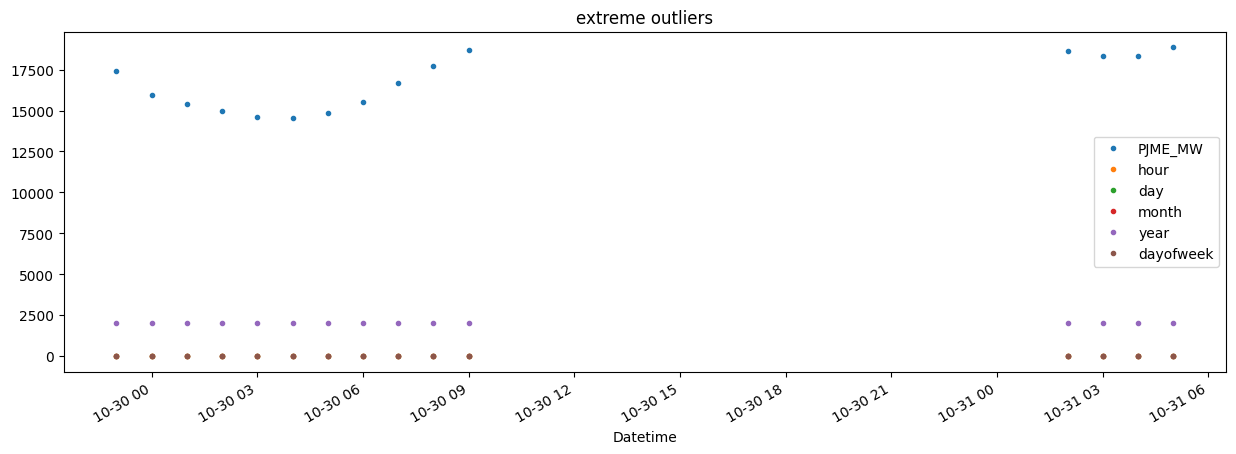

In [23]:
df.query('PJME_MW < 19000').plot(figsize=(15, 5), title='extreme outliers', style='.')

In [24]:
#need to remove extreme outliers that are irregular/unrelated to hours
df = df.query('PJME_MW > 19000').copy()

4.0 Modelling and forecasting 

(just testing manual test/split with xgboost)

(recomended to use time series cross validation such as in 5.0)

Train / Test split

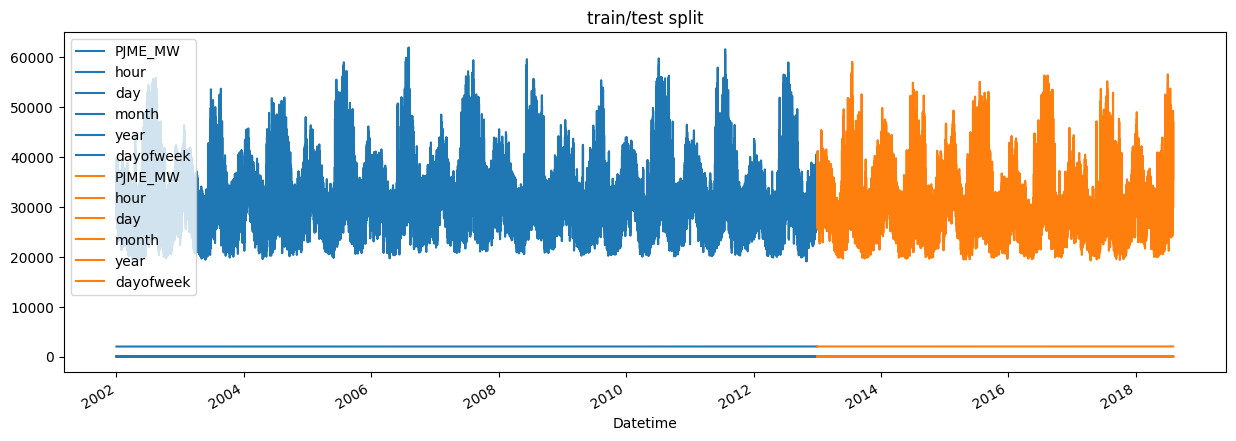

In [25]:
train = df.loc[df.index < '2013-01-01']
test = df.loc[df.index >= '2013-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, color=color_pallate[0], label='train', title='train/test split')
test.plot(ax=ax, color=color_pallate[1], label='test')
plt.show()

In [26]:
train = create_features(train)
test = create_features(test)

In [27]:
train.head()

,PJME_MW,hour,day,month,year,dayofweek
Datetime,,,,,,
2002-12-31 01:00:00,26498.0,1,31,12,2002,1
2002-12-31 02:00:00,25147.0,2,31,12,2002,1
2002-12-31 03:00:00,24574.0,3,31,12,2002,1
2002-12-31 04:00:00,24393.0,4,31,12,2002,1
2002-12-31 05:00:00,24860.0,5,31,12,2002,1


In [28]:
train.columns

Index(['PJME_MW', 'hour', 'day', 'month', 'year', 'dayofweek'], dtype='object')

In [29]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'day', 'month', 'year', 'dayofweek']
TARGET = 'PJME_MW'

In [30]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

Modelling

In [31]:
xg = xgb.XGBRegressor(n_estimators=1000,
                      max_depth=5,
                      learning_rate=0.005,
                      subsample=1,
                      random_state=5,
                      early_stopping_rounds=50,
                      )
xg.fit(x_train, y_train,
       eval_set=[(x_train, y_train), (x_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:32896.16607	validation_1-rmse:31895.79778
[100]	validation_0-rmse:20152.91543	validation_1-rmse:19188.68810
[200]	validation_0-rmse:12538.72746	validation_1-rmse:11672.33906
[300]	validation_0-rmse:8081.17982	validation_1-rmse:7397.76757
[400]	validation_0-rmse:5575.85411	validation_1-rmse:5159.24768
[500]	validation_0-rmse:4261.71310	validation_1-rmse:4217.49195
[600]	validation_0-rmse:3626.63235	validation_1-rmse:3873.76578
[700]	validation_0-rmse:3319.03340	validation_1-rmse:3760.29488
[800]	validation_0-rmse:3149.66362	validation_1-rmse:3716.51196
[900]	validation_0-rmse:3053.52656	validation_1-rmse:3706.57942
[999]	validation_0-rmse:2981.84030	validation_1-rmse:3702.85233


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=5, ...)

In [32]:
xg.feature_importances_

array([0.5581405 , 0.02979274, 0.1768725 , 0.02834166, 0.20685256],
      dtype=float32)

<AxesSubplot: title={'center': 'Feature Importance'}>

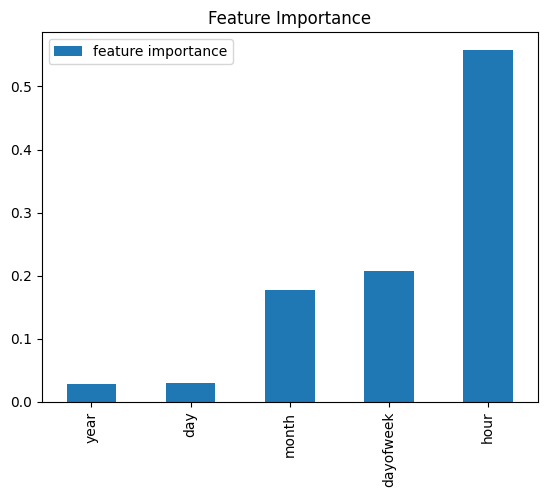

In [33]:
fi = pd.DataFrame(data=xg.feature_importances_, 
             index=xg.feature_names_in_, 
             columns=['feature importance'],)
fi.sort_values('feature importance').plot(kind='bar', title='Feature Importance')

Forecasting

In [34]:
test['prediction'] = xg.predict(x_test)

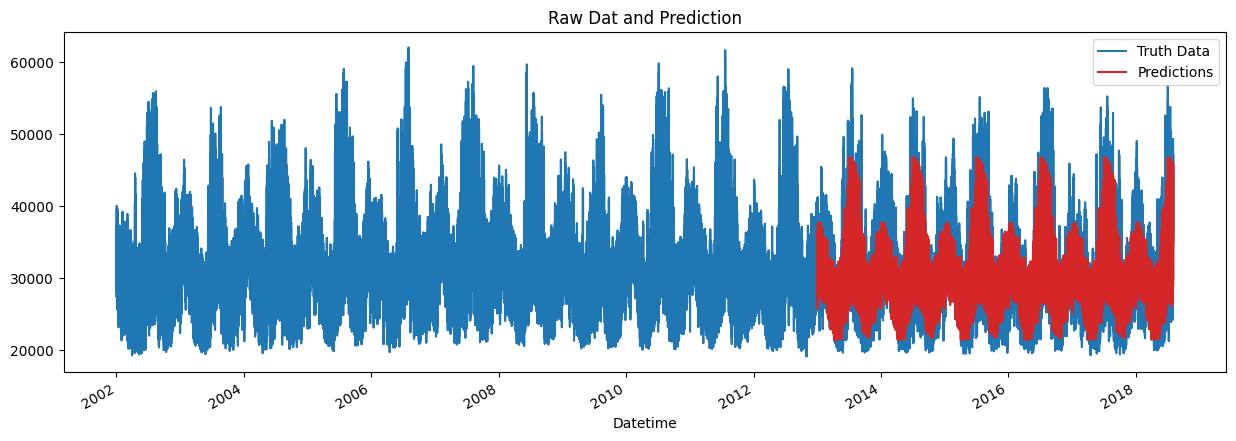

In [35]:
df = df.merge(test[['prediction']], how='left',
            left_index=True, 
            right_index=True)

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, color=color_pallate[3])
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction' )
plt.show()

In [36]:
query = '''
SELECT *
FROM test
WHERE dayofweek = 0
AND day <=7
AND year = 2017
AND month = 12
'''

a1 = ps.sqldf(query)
a1.head(1)

,Datetime,PJME_MW,hour,day,month,year,dayofweek,prediction
0,2017-12-04 01:00:00.000000,26472.0,1,4,12,2017,0,26451.931641


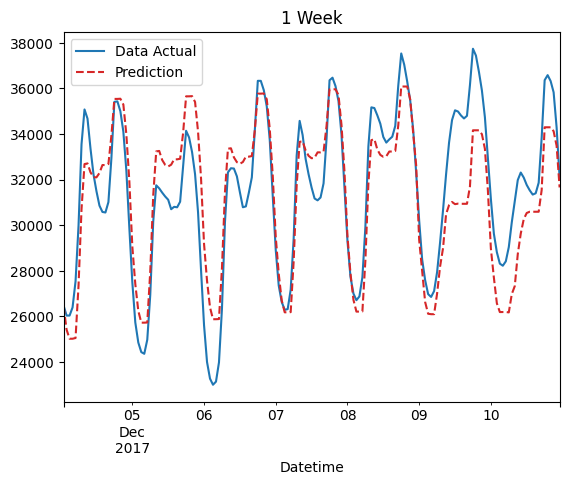

In [37]:
ax = df.loc[(df.index > '2017-12-04') & (df.index < '2017-12-11')]['PJME_MW']\
    .plot()
df.loc[(df.index > '2017-12-04') & (df.index < '2017-12-11')]['prediction']\
    .plot(ax=ax, color=color_pallate[3], style='--')
plt.legend(['Data Actual', 'Prediction'])
ax.set_title('1 Week')
plt.show()

In [38]:
df.head()

,PJME_MW,hour,day,month,year,dayofweek,prediction
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,2002,1,NaN


In [39]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(score)

3702.852329354152


### 5.0 Time series cross validation

In [40]:
df = df.drop('prediction', axis = 1)

In [41]:
df.head()

,PJME_MW,hour,day,month,year,dayofweek
Datetime,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,2002,1


The data that we will train using cross-validation. 

to see the representation of how the timeseries split uncomment

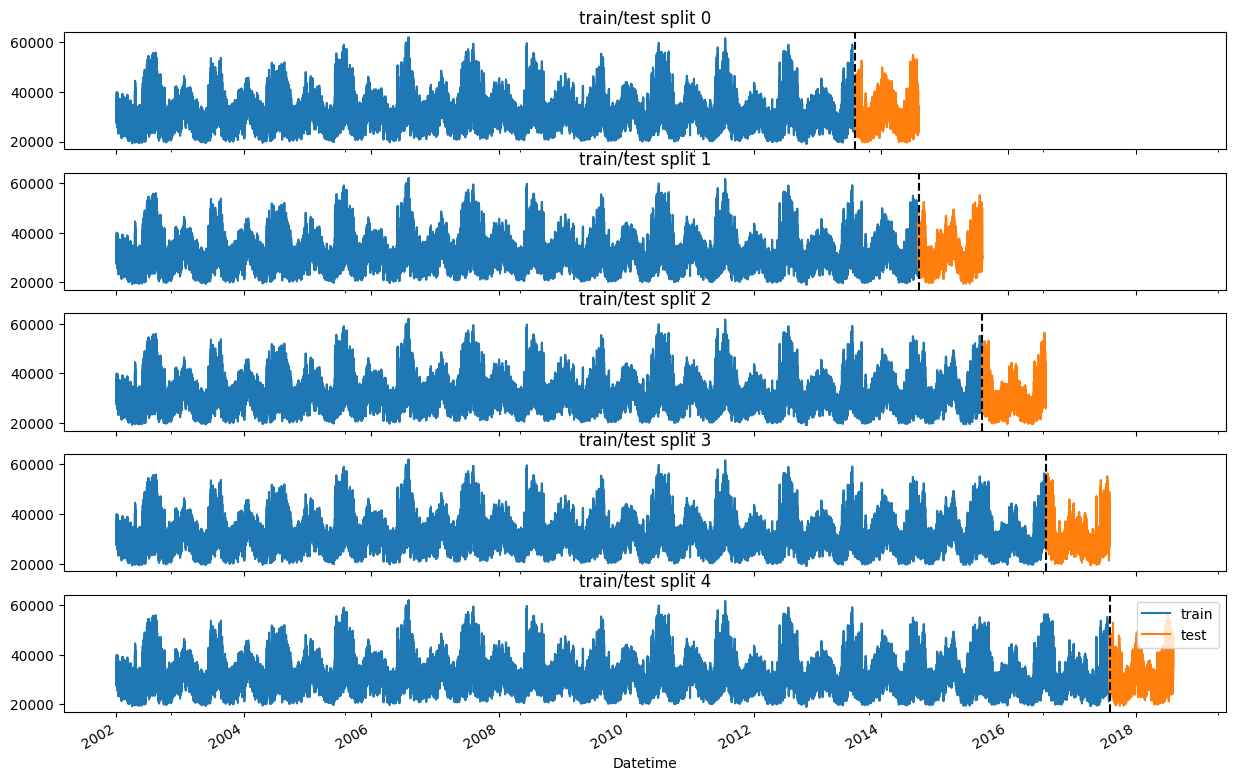

In [42]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()
fig, axs = plt.subplots(5, 1, figsize=(15, 10),
                        sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], 
                          color=color_pallate[0], 
                          label='train', 
                          title=f'train/test split {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         color=color_pallate[1], 
                         label='test')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    plt.legend(['train', 'test'])
    fold += 1
plt.show()

Lag features

In [43]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [44]:
df = add_lags(df)

In [45]:
df.head()

,PJME_MW,hour,day,month,year,dayofweek,lag1,lag2,lag3
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,2002,1,NaN,NaN,NaN


Train using cross-validation

In [46]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['hour', 'day', 'month', 'year', 
                'dayofweek', 'lag1', 'lag2','lag3']
    TARGET = 'PJME_MW'
    
    x_train = train[FEATURES]
    y_train = train[TARGET]
    
    x_test = test[FEATURES]
    y_test = test[TARGET]
    
    xg = xgb.XGBRegressor(n_estimators=1000,
                      max_depth=5,
                      learning_rate=0.003,
                      subsample=1,
                      random_state=5,
                      early_stopping_rounds=50,
                      )
    xg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=200)
    
    y_pred = xg.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    fold += 1
    print(f'folds completed :{fold}')

[0]	validation_0-rmse:32959.57658	validation_1-rmse:32182.88601
[200]	validation_0-rmse:18342.02529	validation_1-rmse:17736.29004
[400]	validation_0-rmse:10484.07099	validation_1-rmse:10062.29206
[600]	validation_0-rmse:6405.04867	validation_1-rmse:6258.87048
[800]	validation_0-rmse:4442.47832	validation_1-rmse:4617.08295
[999]	validation_0-rmse:3608.38225	validation_1-rmse:3978.48300
folds completed :1
[0]	validation_0-rmse:32898.62845	validation_1-rmse:32367.32509
[200]	validation_0-rmse:18311.51879	validation_1-rmse:18074.01455
[400]	validation_0-rmse:10478.63940	validation_1-rmse:10485.07881
[600]	validation_0-rmse:6418.82412	validation_1-rmse:6599.82399
[800]	validation_0-rmse:4468.76125	validation_1-rmse:4757.39580
[999]	validation_0-rmse:3639.04031	validation_1-rmse:3934.50552
folds completed :2
[0]	validation_0-rmse:32857.57242	validation_1-rmse:31297.32124
[200]	validation_0-rmse:18288.88211	validation_1-rmse:16956.01835
[400]	validation_0-rmse:10468.90526	validation_1-rmse:93

In [47]:
print(f'Aevrage score across folds: {np.mean(scores)}')
print(f'fold scores: {scores}')

Aevrage score across folds: 4051.37637701143
fold scores: [3978.4830052939365, 3934.5055176916885, 3648.3442620950186, 4462.824662938462, 4232.724437038046]


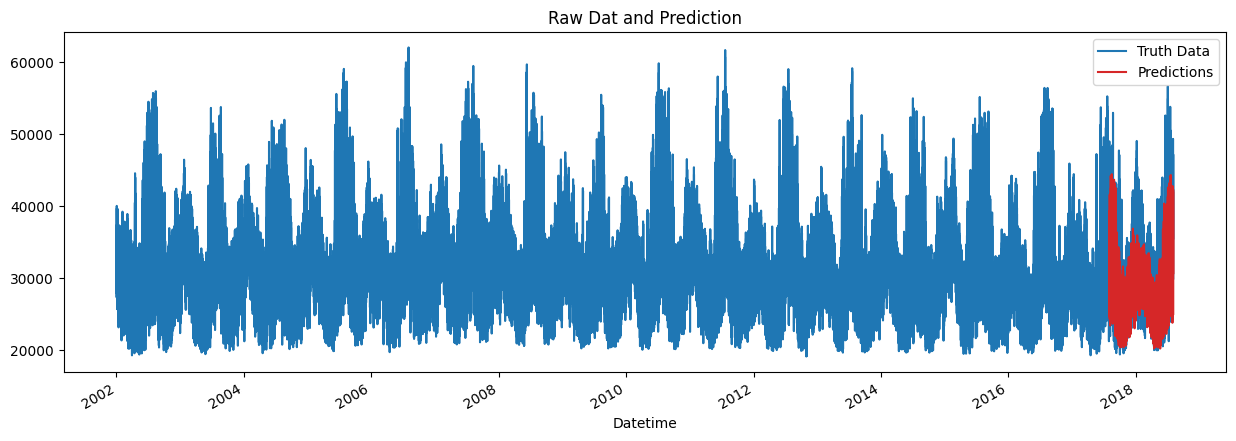

In [48]:
test['prediction'] = xg.predict(x_test)
df = df.merge(test[['prediction']], how='left',
            left_index=True, 
            right_index=True)

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, color=color_pallate[3])
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction' )
plt.show()

Future Forecasting

In [49]:
df.columns

Index(['PJME_MW', 'hour', 'day', 'month', 'year', 'dayofweek', 'lag1', 'lag2',
       'lag3', 'prediction'],
      dtype='object')

In [50]:
df = create_features(df)

FEATURES = ['hour', 'day', 'month', 'year',
            'dayofweek', 'lag1', 'lag2', 'lag3']
TARGET= 'PJME_MW'

x_all = df[FEATURES]
y_all = df[TARGET]

xg = xgb.XGBRegressor(n_estimators=10000,
                      max_depth=5,
                      learning_rate=0.004,
                      subsample=1,
                      random_state=5,
                      early_stopping_rounds=50,
                      )
xg.fit(x_all, y_all,
        eval_set=[(x_all, y_all)],
        verbose=200)
                      

[0]	validation_0-rmse:32595.39783
[200]	validation_0-rmse:15005.93423
[400]	validation_0-rmse:7451.43509
[600]	validation_0-rmse:4524.00507
[800]	validation_0-rmse:3594.72082
[1000]	validation_0-rmse:3319.03272
[1200]	validation_0-rmse:3205.11008
[1400]	validation_0-rmse:3133.52572
[1600]	validation_0-rmse:3078.48016
[1800]	validation_0-rmse:3038.31485
[2000]	validation_0-rmse:3004.06641
[2200]	validation_0-rmse:2964.16581
[2400]	validation_0-rmse:2939.02670
[2600]	validation_0-rmse:2913.41437
[2800]	validation_0-rmse:2889.37438
[3000]	validation_0-rmse:2863.03766
[3200]	validation_0-rmse:2838.21724
[3400]	validation_0-rmse:2819.49735
[3600]	validation_0-rmse:2801.00588
[3800]	validation_0-rmse:2782.99757
[4000]	validation_0-rmse:2765.07101
[4200]	validation_0-rmse:2748.54808
[4400]	validation_0-rmse:2733.77436
[4600]	validation_0-rmse:2716.94007
[4800]	validation_0-rmse:2697.81433
[5000]	validation_0-rmse:2683.66009
[5200]	validation_0-rmse:2669.86314
[5400]	validation_0-rmse:2656.937

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.004, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=5, ...)

In [51]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [52]:
#create fututre skeleton dataframe
future = pd.date_range('2018-08-03', '2019-08-03', freq='H')
df_future = pd.DataFrame(index=future)
df_future['isfuture'] = True
df['isfuture'] = False
df_and_future = pd.concat([df, df_future])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [53]:
future_w_feature = df_and_future.query('isfuture == True').copy()

In [54]:
future_w_feature['Pred'] = xg.predict(future_w_feature[FEATURES])

<AxesSubplot: title={'center': 'Future Forecast'}>

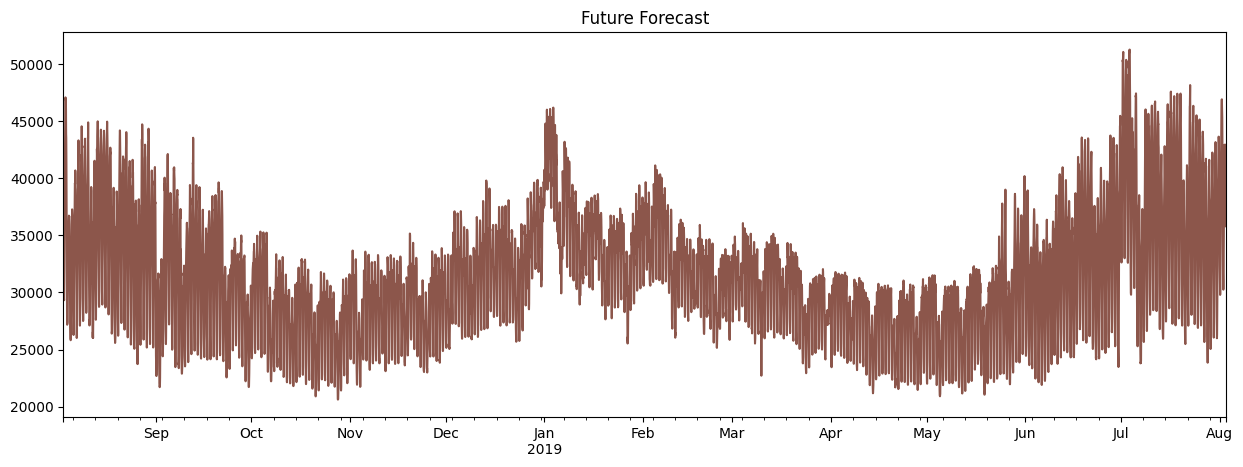

In [55]:
future_w_feature['Pred'].plot(figsize=(15, 5), 
                              color=color_pallate[5],
                              title='Future Forecast')

to save and reload model in the future

In [56]:
#xg.save_model('xg.json')